## Generative document comprehension

#github:@RayenR1 | linkedin :Rayen Jlassi

[2025/03/28 16:11:34] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\jlassi/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.4, det_db_box_thresh=0.5, det_db_unclip_ratio=2.0, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\jlassi/.paddleocr/whl\\rec\\latin\\latin_PP-OCRv3_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_

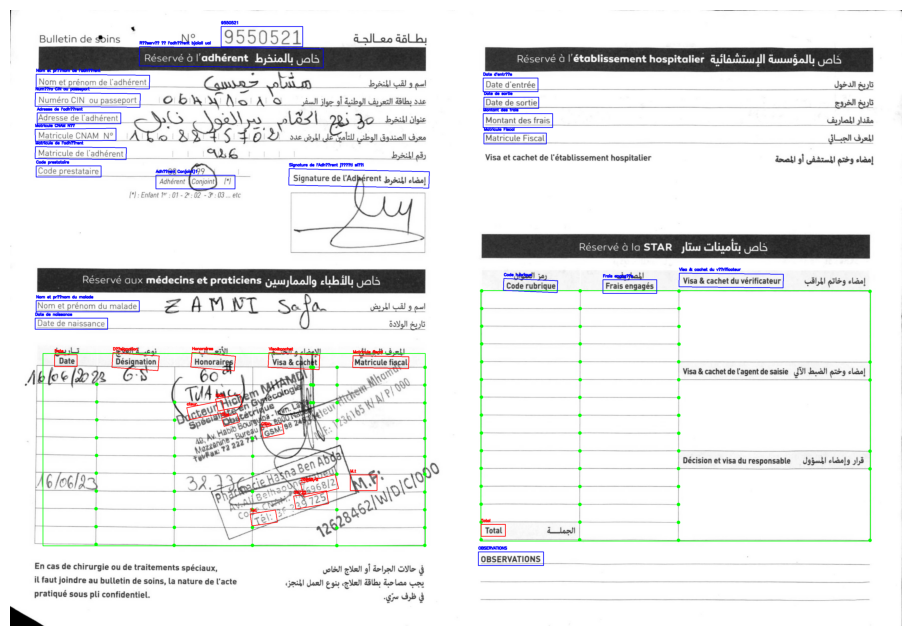

In [21]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import random
import re
from paddleocr import PaddleOCR
import json
import requests  

# -------- CONFIGURATION ----------
OCR_ENGINE = PaddleOCR(
    use_angle_cls=True,  # Active la classification de l'angle du texte pour corriger les rotations
    lang="fr",  # Définit la langue pour la reconnaissance de texte (ici, français)
    use_gpu=False,  # Désactive l'utilisation du GPU (True pour activer si disponible)
    det_db_thresh=0.4,  # Seuil de détection des boîtes de texte (plus bas = plus sensible)
    det_db_box_thresh=0.5,  # Seuil de filtrage des boîtes détectées (évite les fausses détections)
    det_db_unclip_ratio=2.0,  # Facteur d'agrandissement des boîtes détectées pour une meilleure capture du texte
    rec_algorithm="SVTR_LCNet",  # Algorithme utilisé pour la reconnaissance de texte
    max_text_length=100,  # Longueur maximale du texte reconnu par l'OCR
)
 


OLLAMA_API_URL = "http://localhost:11434/api/generate"  # Adjust this to your Ollama endpoint

# -------- TABLE DETECTION FUNCTIONS --------
def adaptive_threshold(imagename, process_background=False, blocksize=15, c=-2):
    """Thresholds an image using OpenCV's adaptiveThreshold."""
    img = cv2.imread(imagename)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if process_background:
        threshold = cv2.adaptiveThreshold(
            gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, blocksize, c
        )
    else:
        threshold = cv2.adaptiveThreshold(
            np.invert(gray),
            255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY,
            blocksize,
            c,
        )
    return img, threshold

def find_lines(threshold, regions=None, direction="horizontal", line_scale=15, iterations=0):
    """Finds horizontal and vertical lines by applying morphological transformations."""
    lines = []
    if direction == "vertical":
        size = threshold.shape[0] // line_scale
        el = cv2.getStructuringElement(cv2.MORPH_RECT, (1, size))
    elif direction == "horizontal":
        size = threshold.shape[1] // line_scale
        el = cv2.getStructuringElement(cv2.MORPH_RECT, (size, 1))
    else:
        raise ValueError("Specify direction as either 'vertical' or 'horizontal'")

    if regions is not None:
        region_mask = np.zeros(threshold.shape)
        for region in regions:
            x, y, w, h = region
            region_mask[y:y + h, x:x + w] = 1
        threshold = np.multiply(threshold, region_mask)

    threshold = cv2.erode(threshold, el)
    threshold = cv2.dilate(threshold, el)
    dmask = cv2.dilate(threshold, el, iterations=iterations)

    try:
        _, contours, _ = cv2.findContours(
            threshold.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )
    except ValueError:
        contours, _ = cv2.findContours(
            threshold.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )

    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        x1, x2 = x, x + w
        y1, y2 = y, y + h
        if direction == "vertical":
            lines.append(((x1 + x2) // 2, y2, (x1 + x2) // 2, y1))
        elif direction == "horizontal":
            lines.append((x1, (y1 + y2) // 2, x2, (y1 + y2) // 2))
    return dmask, lines

def find_contours(vertical, horizontal):
    """Finds table boundaries using OpenCV's findContours."""
    mask = vertical + horizontal
    try:
        _, contours, _ = cv2.findContours(
            mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )
    except ValueError:
        contours, _ = cv2.findContours(
            mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]
    cont = []
    for c in contours:
        c_poly = cv2.approxPolyDP(c, 3, True)
        x, y, w, h = cv2.boundingRect(c_poly)
        cont.append((x, y, w, h))
    return cont, mask

def find_joints(contours, vertical, horizontal):
    """Finds joints/intersections inside each table boundary."""
    joints = np.multiply(vertical, horizontal)
    tables = {}
    for c in contours:
        x, y, w, h = c
        roi = joints[y:y + h, x:x + w]
        try:
            _, jc, _ = cv2.findContours(
                roi.astype(np.uint8), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE
            )
        except ValueError:
            jc, _ = cv2.findContours(
                roi.astype(np.uint8), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE
            )
        if len(jc) <= 4:
            continue
        joint_coords = []
        for j in jc:
            jx, jy, jw, jh = cv2.boundingRect(j)
            c1, c2 = x + (2 * jx + jw) // 2, y + (2 * jy + jh) // 2
            joint_coords.append((c1, c2))
        tables[(x, y + h, x + w, y)] = joint_coords
    return tables

# -------- FIELD EXTRACTION FUNCTIONS --------
def contains_arabic(text):
    """Check if the text contains Arabic characters."""
    return bool(re.search("[\\u0600-\\u06FF]", text))

def is_likely_handwritten(text, box, image):
    """Heuristic to detect handwritten text based on text irregularity and box size."""
    width = box[2][0] - box[0][0]
    height = box[2][1] - box[0][1]
    aspect_ratio = width / height if height > 0 else 0
    if aspect_ratio < 0.5 or aspect_ratio > 10 or len(text) < 3:
        return True
    return False

def is_likely_field_name(text):
    """Determine if the text is likely a field name (label) in a form."""
    text = text.strip().upper()
    word_count = len(text.split())
    if word_count > 6:
        return False

    field_keywords = [
        "NOM", "PRENOM", "ADRESSE", "MATRICULE", "DATE", "MONTANT", "CODE",
        "VISA", "HONORAIRES", "DESIGNATION", "TOTAL", "OBSERVATIONS", "FRAIS",
        "NUMERO", "SIGNATURE", "RESERVE", "SORTIE", "ENTREE", "MATRICULE FISCAL"
    ]
    if any(keyword in text for keyword in field_keywords):
        return True

    non_field_patterns = [
        r"BULLETIN DE SOINS",
        r"RESERVE A L'ETABLISSEMENT HOSPITALIER",
        r"RESERVE A STAR",
        r"RESERVE AUX MEDECINS ET PRATICIENS",
        r"POUR LES CHIRURGIES OU DE TRAITEMENTS SPECIAUX",
        r"IL FAUT JOINDRE AU BULLETIN DE SOINS"
    ]
    if any(re.search(pattern, text, re.IGNORECASE) for pattern in non_field_patterns):
        return False

    if len(text) > 50:
        return False

    return True

def extract_text_and_layout(image):
    """Extract text and layout from the image using OCR."""
    image_np = np.array(image)
    results = OCR_ENGINE.ocr(image_np, cls=True)
    extracted_data = []
    
    for line in results:
        if line is None:
            continue
        for word_info in line:
            if word_info is None:
                continue
            text = word_info[1][0]
            confidence = word_info[1][1]
            box = word_info[0]
            
            text = text.replace("??", "é").replace("??", "à").strip()
            
            if confidence < 0.7:
                continue
                
            if contains_arabic(text):
                continue
                
            if is_likely_handwritten(text, box, image_np):
                continue
                
            if len(text) < 2:
                continue
                
            extracted_data.append({"text": text, "box": box})
    return extracted_data

def filter_field_names(extracted_data):
    """Filter the extracted data to keep only boxes that represent field names."""
    filtered_data = []
    for item in extracted_data:
        text = item["text"]
        if is_likely_field_name(text):
            filtered_data.append(item)
    return filtered_data

def is_inside_table(box, table_bbox):
    """Check if a bounding box is inside a table."""
    box_center_x = (box[0][0] + box[2][0]) / 2
    box_center_y = (box[0][1] + box[2][1]) / 2
    for table in table_bbox.keys():
        x1, y2, x2, y1 = table
        if x1 <= box_center_x <= x2 and y1 <= box_center_y <= y2:
            return True
    return False

def annotate_image(image_path, table_bbox, extracted_data, output_path="combined_result.jpg"):
    """Annotate the image with bounding boxes for tables and fields."""
    image = cv2.imread(image_path)
    if image is None:
        print("[ERROR] Unable to load image for annotation.")
        return
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Annotate tables
    for tab in table_bbox.keys():
        x1, y2, x2, y1 = tab
        cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        for cord in table_bbox[tab]:
            image = cv2.circle(image, (cord[0], cord[1]), radius=7, color=(0, 255, 0), thickness=-1)

    # Annotate fields
    for item in extracted_data:
        box = np.array(item["box"], np.int32).reshape((-1, 1, 2))
        # Color based on whether the field is inside a table
        color = (255, 0, 0) if is_inside_table(item["box"], table_bbox) else (0, 0, 255)
        cv2.polylines(image, [box], isClosed=True, color=color, thickness=2)
        
        text_x, text_y = box[0][0][0], box[0][0][1] - 10
        cv2.putText(image, item["text"], (text_x, text_y),
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=color, thickness=2, lineType=cv2.LINE_AA)
    
    cv2.imwrite(output_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

# -------- NEW FUNCTIONS FOR SAVING AND FILTERING --------
def save_boxes_to_file(extracted_data, filename="detected_boxes.json"):
    """Save the detected boxes to a JSON file."""
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(extracted_data, f, ensure_ascii=False, indent=4)
    print(f"[INFO] Detected boxes saved to {filename}")

def load_common_fields():
    """Predefined list of common fields in a bulletin de soins that may contain personal data."""
    common_fields = [
        "N°",
        "Bultin de soins",
        "numero de Bulltin",
        "NOM ET PRENOM DE L'ADHERENT",
        "NUMERO CIN OU PASSEPORT",
        "MATRICULE CNAM N°",
        "MATRICULE DE L'ADHERENT",
        "ADRESSE DE L'ADHERENT",
        "CODE POSTAL",
        "SIGNATURE DE L'ADHERENT",
        "ASSURE",
        "CONJOINT",
        "ENFANT",
        "NOM ET PRENOM DU BENEFICIAIRE",
        "NOM ET PRENOM DU MALADE",
        "DATE DE NAISSANCE",
        "DATE",
        "DENTS",
        "ACTE MEDICAL",
        "HONORAIRES",
        "COEFFICIENT",
        "DESIGNATION DE L'ACTE",
        "MONTANT DES HONORAIRES",
        "NOM ET PRENOM DU PRATICIEN",
        "MATRICULE FISCAL",
        "VISA ET CACHET DU PRATICIEN",
        "CACHET ET SIGNATURE DU PRATICIEN",
        "DATE D'ENTREE",
        "DATE DE SORTIE",
        "MONTANT DES FRAIS",
        "VISA ET CACHET DE L'ETABLISSEMENT HOSPITALIER",
        "OBSERVATIONS",
        "TOTAL",
        "NUMERO DE CONTRAT",
        "CODE PRESTATAIRE",
        "CONTRAT N°",
        "MATRICULE ADHERENT",
        "EXECUTIONS DES ORDONNANCES",
        "RUBRIQUE",
        "FRAIS ENGAGES",
        "BASE DE CALCUL",
        "Désignation",
        "Visa&Cache",
        "code rubrique",
        "Montant",
        "Frais engagés",
        "visa&cachet de verificateur",
        "Contractant",
        "Contrat N",
        "Contractant et cachet",
        "Nom et prénom de l'assuré",
        "Nom et prénom du nénéficiaire",
        "Nom de la societe",
        "Matricule"
    ]
    return [field.upper() for field in common_fields]

def query_ollama(text):
    """Query Ollama LLaMA 3 (8B) to check if a box is a personal data field."""
    print(f"[INFO] Querying Ollama for text: '{text}'")
    prompt = (
        "You are an AI assistant specialized in processing 'bulletin de soins' forms, which are healthcare reimbursement forms used in Tunisia. "
        "A 'bulletin de soins' is a document used to request reimbursement for medical expenses. It typically contains several sections: "
        "1. Personal information of the insured person (adherent) and beneficiary, such as names, addresses, identification numbers (e.g., CIN, passport, CNAM number), and dates of birth. "
        "2. Medical procedure details, including dates of care, descriptions of medical acts (e.g., 'Désignation'), fees, prices, and amounts (e.g., 'Montant des honoraires', 'Montant des frais'). "
        "3. Practitioner details, such as the practitioner's name, tax registration number, and their signature and stamp (e.g., 'Visa et cachet du praticien'). "
        "4. Hospitalization details, if applicable, including entry and exit dates, and associated costs. "
        "5. Additional fields like observations, totals, contract numbers, and provider codes. "
        "These forms generally include fields for signatures (e.g., 'Signature de l'adhérent'), stamps (e.g., 'Cachet et signature du praticien'), fees, and prices, as these are critical for validation and reimbursement. "
        "Your task is to determine whether a given text is a field label in a 'bulletin de soins' form that requires personal data to be filled in. "
        "Personal data includes information like names, dates of birth, addresses, identification numbers, dates of care, practitioner names, signatures, stamps, fees, prices, and other identifiers. "
        "Important: If the text appears to be a name or surname (e.g., 'SAFA'), it is likely a filled-in value, not a field label, so you should respond with 'Non'. "
        "Important: If the text appears to be a date in any format (e.g., 'jj-mm-yy', 'dd/mm/yyyy', 'yyyy-mm-dd', or textual dates like '12 janvier 2023'), it is likely a filled-in value, not a field label, so you should respond with 'Non'. "
        "Given the text string below, respond with 'Oui' (Yes) if it is a field label that would be filled with personal data, or 'Non' (No) if it is not. "
        "You must respond with a single word: 'Oui' or 'Non'. Do not include any additional explanation, text, or punctuation. Only 'Oui' or 'Non' is acceptable.\n\n"
        f"Text: '{text}'"
    )
    payload = {
        "model": "llama3:8b",
        "prompt": prompt,
        "stream": False
    }
    try:
        response = requests.post(OLLAMA_API_URL, json=payload, timeout=10)
        response.raise_for_status()
        result = response.json().get("response", "").strip()
        print(f"[INFO] Ollama response for '{text}': {result}")
        if result not in ["Oui", "Non"]:
            print(f"[WARNING] Ollama returned invalid response '{result}' for '{text}'. Defaulting to 'Non'.")
            return False
        return result == "Oui"
    except requests.exceptions.RequestException as e:
        print(f"[ERROR] Failed to query Ollama for '{text}': {e}")
        return False  # Default to False if query fails

def filter_boxes_with_ollama(extracted_data, common_fields):
    """Separate boxes into common fields and suspect fields, then verify suspect fields with Ollama."""
    common_boxes = []
    suspect_boxes = []

    # Step 1: Separate boxes into common fields and suspect fields
    for item in extracted_data:
        # Normalize the text: remove extra spaces, normalize apostrophes, and convert to uppercase
        text = item["text"].replace("’", "'").strip()  # Normalize apostrophes
        text = " ".join(text.split())  # Remove extra spaces
        text_upper = text.upper()
        print(f"[DEBUG] Normalized text: '{text_upper}'")

        if text_upper in common_fields:
            print(f"[INFO] Keeping '{text}' as it matches a common field.")
            common_boxes.append(item)
        else:
            print(f"[INFO] '{text}' not in common_fields, marking as suspect for Ollama verification.")
            suspect_boxes.append(item)

    # Step 2: Save suspect fields to a JSON file
    save_boxes_to_file(suspect_boxes, "suspect_fields.json")

    # Step 3: Verify suspect fields with Ollama
    verified_suspect_boxes = []
    for item in suspect_boxes:
        text = item["text"]
        if query_ollama(text):
            print(f"[INFO] Keeping '{text}' as Ollama confirmed it’s a personal data field.")
            verified_suspect_boxes.append(item)
        else:
            print(f"[INFO] Removing '{text}' as Ollama confirmed it’s not a personal data field.")

    # Step 4: Combine common fields and verified suspect fields
    final_filtered_boxes = common_boxes + verified_suspect_boxes
    return final_filtered_boxes

def main(doc_path):
    """Main function to process the document, annotate it, and filter boxes."""
    # Step 1: Table Detection
    process_background = False
    threshold_blocksize = 15
    threshold_constant = -2
    image, threshold = adaptive_threshold(
        doc_path,
        process_background=process_background,
        blocksize=threshold_blocksize,
        c=threshold_constant,
    )

    regions = None
    iterations = 0
    line_scale = 15
    vertical_mask, vertical_segments = find_lines(
        threshold,
        regions=regions,
        direction="vertical",
        line_scale=line_scale,
        iterations=iterations,
    )
    horizontal_mask, horizontal_segments = find_lines(
        threshold,
        regions=regions,
        direction="horizontal",
        line_scale=line_scale,
        iterations=iterations,
    )

    contours, mask = find_contours(vertical_mask, horizontal_mask)
    table_bbox = find_joints(contours, vertical_mask, horizontal_mask)

    # Step 2: Field Extraction
    image_pil = Image.open(doc_path).convert("RGB")
    extracted_data = extract_text_and_layout(image_pil)
    filtered_data = filter_field_names(extracted_data)

    # Step 3: Save the initial detected boxes
    save_boxes_to_file(filtered_data, "initial_detected_boxes.json")

    # Step 4: Load common fields and filter with Ollama
    common_fields = load_common_fields()
    final_filtered_data = filter_boxes_with_ollama(filtered_data, common_fields)

    # Step 5: Save the final filtered boxes
    save_boxes_to_file(final_filtered_data, "final_filtered_boxes.json")

    # Step 6: Annotate the image with tables and final filtered fields
    annotate_image(doc_path, table_bbox, final_filtered_data, output_path="combined_result.jpg")

if __name__ == "__main__":
    document_path = r"C:\Users\jlassi\Desktop\testYolo\notebooks\image.png"
    main(document_path)

Ollama corresction

[2025/03/29 17:52:59] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\jlassi/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.4, det_db_box_thresh=0.5, det_db_unclip_ratio=2.0, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\jlassi/.paddleocr/whl\\rec\\latin\\latin_PP-OCRv3_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_

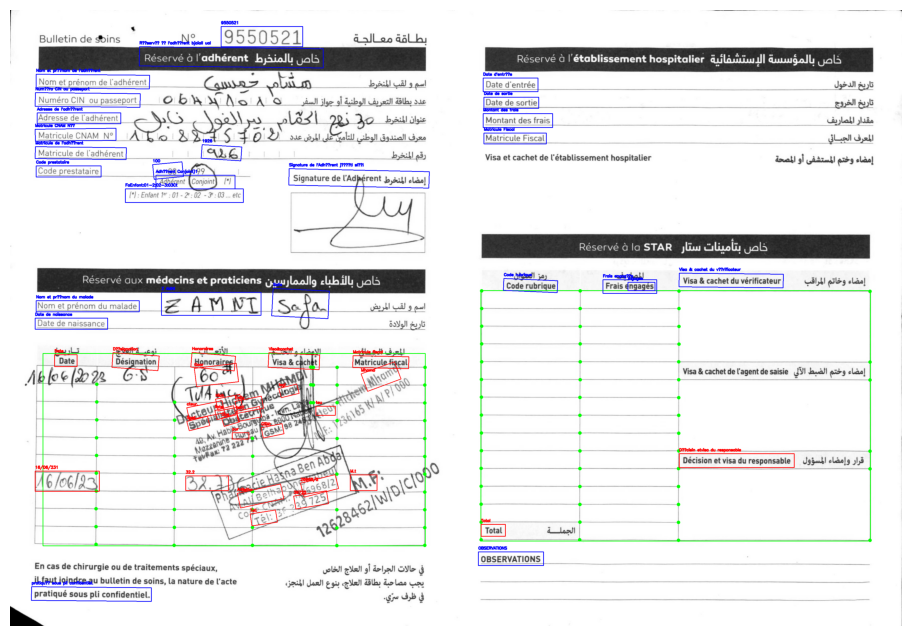

In [20]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import re
from paddleocr import PaddleOCR
import json
import requests

# -------- CONFIGURATION ----------
OCR_ENGINE = PaddleOCR(
    use_angle_cls=True,
    lang="fr",
    use_gpu=False,
    det_db_thresh=0.4,
    det_db_box_thresh=0.5,
    det_db_unclip_ratio=2.0,
    rec_algorithm="SVTR_LCNet",
    max_text_length=100,
)

OLLAMA_API_URL = "http://localhost:11434/api/generate"

# -------- TABLE DETECTION FUNCTIONS --------
def adaptive_threshold(imagename, process_background=False, blocksize=15, c=-2):
    """Thresholds an image using OpenCV's adaptiveThreshold."""
    img = cv2.imread(imagename)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if process_background:
        threshold = cv2.adaptiveThreshold(
            gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, blocksize, c
        )
    else:
        threshold = cv2.adaptiveThreshold(
            np.invert(gray),
            255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY,
            blocksize,
            c,
        )
    return img, threshold

def find_lines(threshold, regions=None, direction="horizontal", line_scale=15, iterations=0):
    """Finds horizontal and vertical lines by applying morphological transformations."""
    lines = []
    if direction == "vertical":
        size = threshold.shape[0] // line_scale
        el = cv2.getStructuringElement(cv2.MORPH_RECT, (1, size))
    elif direction == "horizontal":
        size = threshold.shape[1] // line_scale
        el = cv2.getStructuringElement(cv2.MORPH_RECT, (size, 1))
    else:
        raise ValueError("Specify direction as either 'vertical' or 'horizontal'")

    if regions is not None:
        region_mask = np.zeros(threshold.shape)
        for region in regions:
            x, y, w, h = region
            region_mask[y:y + h, x:x + w] = 1
        threshold = np.multiply(threshold, region_mask)

    threshold = cv2.erode(threshold, el)
    threshold = cv2.dilate(threshold, el)
    dmask = cv2.dilate(threshold, el, iterations=iterations)

    try:
        _, contours, _ = cv2.findContours(
            threshold.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )
    except ValueError:
        contours, _ = cv2.findContours(
            threshold.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )

    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        x1, x2 = x, x + w
        y1, y2 = y, y + h
        if direction == "vertical":
            lines.append(((x1 + x2) // 2, y2, (x1 + x2) // 2, y1))
        elif direction == "horizontal":
            lines.append((x1, (y1 + y2) // 2, x2, (y1 + y2) // 2))
    return dmask, lines

def find_contours(vertical, horizontal):
    """Finds table boundaries using OpenCV's findContours."""
    mask = vertical + horizontal
    try:
        _, contours, _ = cv2.findContours(
            mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )
    except ValueError:
        contours, _ = cv2.findContours(
            mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]
    cont = []
    for c in contours:
        c_poly = cv2.approxPolyDP(c, 3, True)
        x, y, w, h = cv2.boundingRect(c_poly)
        cont.append((x, y, w, h))
    return cont, mask

def find_joints(contours, vertical, horizontal):
    """Finds joints/intersections inside each table boundary."""
    joints = np.multiply(vertical, horizontal)
    tables = {}
    for c in contours:
        x, y, w, h = c
        roi = joints[y:y + h, x:x + w]
        try:
            _, jc, _ = cv2.findContours(
                roi.astype(np.uint8), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE
            )
        except ValueError:
            jc, _ = cv2.findContours(
                roi.astype(np.uint8), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE
            )
        if len(jc) <= 4:
            continue
        joint_coords = []
        for j in jc:
            jx, jy, jw, jh = cv2.boundingRect(j)
            c1, c2 = x + (2 * jx + jw) // 2, y + (2 * jy + jh) // 2
            joint_coords.append((c1, c2))
        tables[(x, y + h, x + w, y)] = joint_coords
    return tables

# -------- FIELD EXTRACTION FUNCTIONS --------
def contains_arabic(text):
    return bool(re.search("[\\u0600-\\u06FF]", text))

def is_likely_handwritten(text, box, image):
    width = box[2][0] - box[0][0]
    height = box[2][1] - box[0][1]
    aspect_ratio = width / height if height > 0 else 0
    if aspect_ratio < 0.5 or aspect_ratio > 10 or len(text) < 3:
        return True
    return False

def is_likely_field_name(text):
    text = text.strip().upper()
    word_count = len(text.split())
    if word_count > 6:
        return False

    field_keywords = [
        "NOM", "PRENOM", "ADRESSE", "MATRICULE", "DATE", "MONTANT", "CODE",
        "VISA", "HONORAIRES", "DESIGNATION", "TOTAL", "OBSERVATIONS", "FRAIS",
        "NUMERO", "SIGNATURE", "RESERVE", "SORTIE", "ENTREE", "MATRICULE FISCAL"
    ]
    if any(keyword in text for keyword in field_keywords):
        return True

    non_field_patterns = [
        r"BULLETIN DE SOINS",
        r"RESERVE A L'ETABLISSEMENT HOSPITALIER",
        r"RESERVE A STAR",
        r"RESERVE AUX MEDECINS ET PRATICIENS",
        r"POUR LES CHIRURGIES OU DE TRAITEMENTS SPECIAUX",
        r"IL FAUT JOINDRE AU BULLETIN DE SOINS"
    ]
    if any(re.search(pattern, text, re.IGNORECASE) for pattern in non_field_patterns):
        return False

    if len(text) > 50:
        return False

    return True

def preprocess_image(image, mode):
    """Prétraite l'image selon le mode spécifié."""
    image_np = np.array(image)
    if mode == "grayscale":
        return cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
    elif mode == "rgb":
        return image_np
    elif mode == "binary":
        gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
        return cv2.adaptiveThreshold(
            gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, -2
        )
    elif mode == "contrast":
        img_lab = cv2.cvtColor(image_np, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(img_lab)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
        l = clahe.apply(l)
        img_lab = cv2.merge((l, a, b))
        return cv2.cvtColor(img_lab, cv2.COLOR_LAB2RGB)
    else:
        raise ValueError(f"Mode {mode} non supporté.")

def boxes_overlap(box1, box2, threshold=0.5):
    """Vérifie si deux boîtes se chevauchent avec un seuil d'intersection (IoU)."""
    x1, y1 = box1[0][0], box1[0][1]
    x2, y2 = box1[2][0], box1[2][1]
    x1_p, y1_p = box2[0][0], box2[0][1]
    x2_p, y2_p = box2[2][0], box2[2][1]

    xi1 = max(x1, x1_p)
    yi1 = max(y1, y1_p)
    xi2 = min(x2, x2_p)
    yi2 = min(y2, y2_p)

    inter_width = max(0, xi2 - xi1)
    inter_height = max(0, yi2 - yi1)
    inter_area = inter_width * inter_height

    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2_p - x1_p) * (y2_p - y1_p)
    union_area = box1_area + box2_area - inter_area

    iou = inter_area / union_area if union_area > 0 else 0
    return iou > threshold

def extract_text_and_layout(image):
    """Extract text and layout avec OCR séquentiel sur plusieurs modes."""
    modes = ["grayscale", "rgb", "binary", "contrast"]  # Ordre défini, commence par grayscale
    extracted_data = []

    for mode in modes:
        print(f"[INFO] Applying OCR with {mode} mode")
        preprocessed_img = preprocess_image(image, mode)
        results = OCR_ENGINE.ocr(preprocessed_img, cls=True)

        if results is None:
            continue
        for line in results:
            if line is None:
                continue
            for word_info in line:
                if word_info is None:
                    continue
                text = word_info[1][0]
                confidence = word_info[1][1]
                box = word_info[0]

                text = text.replace("??", "é").replace("??", "à").strip()

                if confidence < 0.7:
                    continue
                if contains_arabic(text):
                    continue
                if is_likely_handwritten(text, box, preprocessed_img):
                    continue
                if len(text) < 2:
                    continue

                # Vérifier si la boîte chevauche une boîte existante
                overlaps = False
                for existing in extracted_data:
                    if boxes_overlap(existing["box"], box):
                        overlaps = True
                        break

                # Ajouter uniquement si pas de chevauchement
                if not overlaps:
                    extracted_data.append({"text": text, "box": box})

    print(f"[INFO] Total boxes detected: {len(extracted_data)}")
    return extracted_data

def filter_field_names(extracted_data):
    filtered_data = []
    for item in extracted_data:
        text = item["text"]
        if is_likely_field_name(text):
            filtered_data.append(item)
    return filtered_data

def is_inside_table(box, table_bbox):
    box_center_x = (box[0][0] + box[2][0]) / 2
    box_center_y = (box[0][1] + box[2][1]) / 2
    for key in table_bbox.keys():
        x1, y2, x2, y1 = key
        if x1 <= box_center_x <= x2 and y1 <= box_center_y <= y2:
            return True
    return False

def annotate_image(image_path, table_bbox, extracted_data, output_path="combined_result.jpg"):
    image = cv2.imread(image_path)
    if image is None:
        print("[ERROR] Unable to load image for annotation.")
        return
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    for tab in table_bbox.keys():
        x1, y2, x2, y1 = tab
        cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        for cord in table_bbox[tab]:
            image = cv2.circle(image, (cord[0], cord[1]), radius=7, color=(0, 255, 0), thickness=-1)

    for item in extracted_data:
        box = np.array(item["box"], np.int32).reshape((-1, 1, 2))
        color = (255, 0, 0) if is_inside_table(item["box"], table_bbox) else (0, 0, 255)
        cv2.polylines(image, [box], isClosed=True, color=color, thickness=2)

        text_x, text_y = box[0][0][0], box[0][0][1] - 10
        cv2.putText(image, item["text"], (text_x, text_y),
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=color, thickness=2, lineType=cv2.LINE_AA)

    cv2.imwrite(output_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

# -------- NEW FUNCTIONS FOR SAVING AND FILTERING --------
def save_boxes_to_file(extracted_data, filename="detected_boxes.json"):
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(extracted_data, f, ensure_ascii=False, indent=4)
    print(f"[INFO] Detected boxes saved to {filename}")

def load_common_fields():
    common_fields = [
        "N°", "Bultin de soins", "numero de Bulltin", "NOM ET PRENOM DE L'ADHERENT",
        "NUMERO CIN OU PASSEPORT", "MATRICULE CNAM N°", "MATRICULE DE L'ADHERENT",
        "ADRESSE DE L'ADHERENT", "CODE POSTAL", "SIGNATURE DE L'ADHERENT", "ASSURE",
        "CONJOINT", "ENFANT", "NOM ET PRENOM DU BENEFICIAIRE", "NOM ET PRENOM DU MALADE",
        "DATE DE NAISSANCE", "DATE", "DENTS", "ACTE MEDICAL", "HONORAIRES", "COEFFICIENT",
        "DESIGNATION DE L'ACTE", "MONTANT DES HONORAIRES", "NOM ET PRENOM DU PRATICIEN",
        "MATRICULE FISCAL", "VISA ET CACHET DU PRATICIEN", "CACHET ET SIGNATURE DU PRATICIEN",
        "DATE D'ENTREE", "DATE DE SORTIE", "MONTANT DES FRAIS",
        "VISA ET CACHET DE L'ETABLISSEMENT HOSPITALIER", "OBSERVATIONS", "TOTAL",
        "NUMERO DE CONTRAT", "CODE PRESTATAIRE", "CONTRAT N°", "MATRICULE ADHERENT",
        "EXECUTIONS DES ORDONNANCES", "RUBRIQUE", "FRAIS ENGAGES", "BASE DE CALCUL",
        "Désignation", "Visa&Cache", "code rubrique", "Montant", "Frais engagés",
        "visa&cachet de verificateur", "Contractant", "Contrat N", "Contractant et cachet",
        "Nom et prénom de l'assuré", "Nom et prénom du nénéficiaire", "Nom de la societe",
        "Matricule"
    ]
    return [field.upper() for field in common_fields]

def query_ollama(text):
    print(f"[INFO] Querying Ollama for text: '{text}'")
    prompt = (
        "You are an AI assistant specialized in processing 'bulletin de soins' forms, which are healthcare reimbursement forms used in Tunisia. "
        "A 'bulletin de soins' is a document used to request reimbursement for medical expenses. It typically contains several sections: "
        "1. Personal information of the insured person (adherent) and beneficiary, such as names, addresses, identification numbers (e.g., CIN, passport, CNAM number), and dates of birth. "
        "2. Medical procedure details, including dates of care, descriptions of medical acts (e.g., 'Désignation'), fees, prices, and amounts (e.g., 'Montant des honoraires', 'Montant des frais'). "
        "3. Practitioner details, such as the practitioner's name, tax registration number, and their signature and stamp (e.g., 'Visa et cachet du praticien'). "
        "4. Hospitalization details, if applicable, including entry and exit dates, and associated costs. "
        "5. Additional fields like observations, totals, contract numbers, and provider codes. "
        "These forms generally include fields for signatures (e.g., 'Signature de l'adhérent'), stamps (e.g., 'Cachet et signature du praticien'), fees, and prices, as these are critical for validation and reimbursement. "
        "Your task is to determine whether a given text is a field label in a 'bulletin de soins' form that requires personal data to be filled in. "
        "Personal data includes information like names, dates of birth, addresses, identification numbers, dates of care, practitioner names, signatures, stamps, fees, prices, and other identifiers. "
        "Important: If the text appears to be a name or surname (e.g., 'SAFA'), it is likely a filled-in value, not a field label, so you should respond with 'Non'. "
        "Important: If the text appears to be a date in any format (e.g., 'jj-mm-yy', 'dd/mm/yyyy', 'yyyy-mm-dd', or textual dates like '12 janvier 2023'), it is likely a filled-in value, not a field label, so you should respond with 'Non'. "
        "Given the text string below, respond with 'Oui' (Yes) if it is a field label that would be filled with personal data, or 'Non' (No) if it is not. "
        "You must respond with a single word: 'Oui' or 'Non'. Do not include any additional explanation, text, or punctuation. Only 'Oui' or 'Non' is acceptable.\n\n"
        f"Text: '{text}'"
    )
    payload = {"model": "llama3:8b", "prompt": prompt, "stream": False}
    try:
        response = requests.post(OLLAMA_API_URL, json=payload, timeout=10)
        response.raise_for_status()
        result = response.json().get("response", "").strip()
        print(f"[INFO] Ollama response for '{text}': {result}")
        if result not in ["Oui", "Non"]:
            print(f"[WARNING] Ollama returned invalid response '{result}' for '{text}'. Defaulting to 'Non'.")
            return False
        return result == "Oui"
    except requests.exceptions.RequestException as e:
        print(f"[ERROR] Failed to query Ollama for '{text}': {e}")
        return False

def filter_boxes_with_ollama(extracted_data, common_fields, use_ollama=True):
    common_boxes = []
    suspect_boxes = []

    for item in extracted_data:
        text = item["text"].replace("’", "'").strip()
        text = " ".join(text.split())
        text_upper = text.upper()
        print(f"[DEBUG] Normalized text: '{text_upper}'")

        if text_upper in common_fields:
            print(f"[INFO] Keeping '{text}' as it matches a common field.")
            common_boxes.append(item)
        else:
            print(f"[INFO] '{text}' not in common_fields, marking as suspect.")
            suspect_boxes.append(item)

    save_boxes_to_file(suspect_boxes, "suspect_fields.json")

    if use_ollama:
        verified_suspect_boxes = []
        for item in suspect_boxes:
            text = item["text"]
            if query_ollama(text):
                print(f"[INFO] Keeping '{text}' as Ollama confirmed it’s a personal data field.")
                verified_suspect_boxes.append(item)
            else:
                print(f"[INFO] Removing '{text}' as Ollama confirmed it’s not a personal data field.")
        final_filtered_boxes = common_boxes + verified_suspect_boxes
    else:
        print("[INFO] Skipping Ollama verification as use_ollama=False.")
        final_filtered_boxes = common_boxes + suspect_boxes

    return final_filtered_boxes

def main(doc_path, use_ollama=True):
    # Step 1: Table Detection
    process_background = False
    threshold_blocksize = 15
    threshold_constant = -2
    image, threshold = adaptive_threshold(
        doc_path,
        process_background=process_background,
        blocksize=threshold_blocksize,
        c=threshold_constant,
    )

    regions = None
    iterations = 0
    line_scale = 15
    vertical_mask, vertical_segments = find_lines(
        threshold,
        regions=regions,
        direction="vertical",
        line_scale=line_scale,
        iterations=iterations,
    )
    horizontal_mask, horizontal_segments = find_lines(
        threshold,
        regions=regions,
        direction="horizontal",
        line_scale=line_scale,
        iterations=iterations,
    )

    contours, mask = find_contours(vertical_mask, horizontal_mask)
    table_bbox = find_joints(contours, vertical_mask, horizontal_mask)

    # Step 2: Field Extraction avec OCR séquentiel
    image_pil = Image.open(doc_path).convert("RGB")
    extracted_data = extract_text_and_layout(image_pil)
    filtered_data = filter_field_names(extracted_data)

    # Step 3: Save the initial detected boxes
    save_boxes_to_file(filtered_data, "initial_detected_boxes.json")

    # Step 4: Load common fields et filtrer avec/sans Ollama
    common_fields = load_common_fields()
    final_filtered_data = filter_boxes_with_ollama(filtered_data, common_fields, use_ollama=use_ollama)

    # Step 5: Save the final filtered boxes
    save_boxes_to_file(final_filtered_data, "final_filtered_boxes.json")

    # Step 6: Annotate the image
    annotate_image(doc_path, table_bbox, final_filtered_data, output_path="combined_result.jpg")

if __name__ == "__main__":
    document_path = r"C:\Users\jlassi\Desktop\testYolo\notebooks\image.png"
    main(document_path, use_ollama=False)

version without LLM from ollama

[2025/03/29 18:00:20] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\jlassi/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.4, det_db_box_thresh=0.5, det_db_unclip_ratio=2.0, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\jlassi/.paddleocr/whl\\rec\\latin\\latin_PP-OCRv3_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_

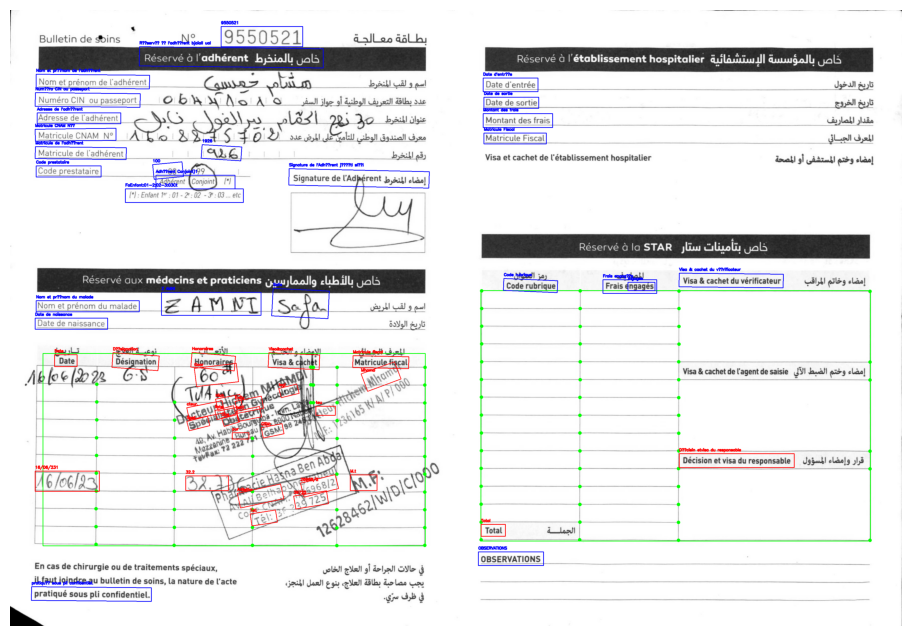

In [23]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import re
from paddleocr import PaddleOCR
import json

# -------- CONFIGURATION ----------
OCR_ENGINE = PaddleOCR(
    use_angle_cls=True,
    lang="fr",
    use_gpu=False,
    det_db_thresh=0.4,
    det_db_box_thresh=0.5,
    det_db_unclip_ratio=2.0,
    rec_algorithm="SVTR_LCNet",
    max_text_length=100,
)

# -------- FONCTIONS DE DÉTECTION DE TABLEAUX --------
def adaptive_threshold(imagename, process_background=False, blocksize=15, c=-2):
    """Applique un seuillage adaptatif à l'image."""
    img = cv2.imread(imagename)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if process_background:
        threshold = cv2.adaptiveThreshold(
            gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, blocksize, c
        )
    else:
        threshold = cv2.adaptiveThreshold(
            np.invert(gray),
            255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY,
            blocksize,
            c,
        )
    return img, threshold

def find_lines(threshold, regions=None, direction="horizontal", line_scale=15, iterations=0):
    """Trouve les lignes horizontales ou verticales."""
    lines = []
    if direction == "vertical":
        size = threshold.shape[0] // line_scale
        el = cv2.getStructuringElement(cv2.MORPH_RECT, (1, size))
    elif direction == "horizontal":
        size = threshold.shape[1] // line_scale
        el = cv2.getStructuringElement(cv2.MORPH_RECT, (size, 1))
    else:
        raise ValueError("Direction doit être 'vertical' ou 'horizontal'")

    if regions is not None:
        region_mask = np.zeros(threshold.shape)
        for region in regions:
            x, y, w, h = region
            region_mask[y:y + h, x:x + w] = 1
        threshold = np.multiply(threshold, region_mask)

    threshold = cv2.erode(threshold, el)
    threshold = cv2.dilate(threshold, el)
    dmask = cv2.dilate(threshold, el, iterations=iterations)

    try:
        _, contours, _ = cv2.findContours(
            threshold.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )
    except ValueError:
        contours, _ = cv2.findContours(
            threshold.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )

    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        x1, x2 = x, x + w
        y1, y2 = y, y + h
        if direction == "vertical":
            lines.append(((x1 + x2) // 2, y2, (x1 + x2) // 2, y1))
        elif direction == "horizontal":
            lines.append((x1, (y1 + y2) // 2, x2, (y1 + y2) // 2))
    return dmask, lines

def find_contours(vertical, horizontal):
    """Trouve les contours des tableaux."""
    mask = vertical + horizontal
    try:
        _, contours, _ = cv2.findContours(
            mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )
    except ValueError:
        contours, _ = cv2.findContours(
            mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]
    cont = []
    for c in contours:
        c_poly = cv2.approxPolyDP(c, 3, True)
        x, y, w, h = cv2.boundingRect(c_poly)
        cont.append((x, y, w, h))
    return cont, mask

def find_joints(contours, vertical, horizontal):
    """Trouve les intersections dans les tableaux."""
    joints = np.multiply(vertical, horizontal)
    tables = {}
    for c in contours:
        x, y, w, h = c
        roi = joints[y:y + h, x:x + w]
        try:
            _, jc, _ = cv2.findContours(
                roi.astype(np.uint8), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE
            )
        except ValueError:
            jc, _ = cv2.findContours(
                roi.astype(np.uint8), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE
            )
        if len(jc) <= 4:
            continue
        joint_coords = []
        for j in jc:
            jx, jy, jw, jh = cv2.boundingRect(j)
            c1, c2 = x + (2 * jx + jw) // 2, y + (2 * jy + jh) // 2
            joint_coords.append((c1, c2))
        tables[(x, y + h, x + w, y)] = joint_coords
    return tables

# -------- FONCTIONS D'EXTRACTION DES CHAMPS --------
def contains_arabic(text):
    return bool(re.search("[\\u0600-\\u06FF]", text))

def is_likely_handwritten(text, box, image):
    width = box[2][0] - box[0][0]
    height = box[2][1] - box[0][1]
    aspect_ratio = width / height if height > 0 else 0
    if aspect_ratio < 0.5 or aspect_ratio > 10 or len(text) < 3:
        return True
    return False

def is_likely_field_name(text):
    text = text.strip().upper()
    word_count = len(text.split())
    if word_count > 6:
        return False

    field_keywords = [
        "NOM", "PRENOM", "ADRESSE", "MATRICULE", "DATE", "MONTANT", "CODE",
        "VISA", "HONORAIRES", "DESIGNATION", "TOTAL", "OBSERVATIONS", "FRAIS",
        "NUMERO", "SIGNATURE", "RESERVE", "SORTIE", "ENTREE", "MATRICULE FISCAL"
    ]
    if any(keyword in text for keyword in field_keywords):
        return True

    non_field_patterns = [
        r"BULLETIN DE SOINS",
        r"RESERVE A L'ETABLISSEMENT HOSPITALIER",
        r"RESERVE A STAR",
        r"RESERVE AUX MEDECINS ET PRATICIENS",
        r"POUR LES CHIRURGIES OU DE TRAITEMENTS SPECIAUX",
        r"IL FAUT JOINDRE AU BULLETIN DE SOINS"
    ]
    if any(re.search(pattern, text, re.IGNORECASE) for pattern in non_field_patterns):
        return False

    if len(text) > 50:
        return False

    return True

def preprocess_image(image, mode):
    """Prétraite l'image selon le mode spécifié."""
    image_np = np.array(image)
    if mode == "grayscale":
        return cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
    elif mode == "rgb":
        return image_np
    elif mode == "binary":
        gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
        return cv2.adaptiveThreshold(
            gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, -2
        )
    elif mode == "contrast":
        img_lab = cv2.cvtColor(image_np, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(img_lab)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
        l = clahe.apply(l)
        img_lab = cv2.merge((l, a, b))
        return cv2.cvtColor(img_lab, cv2.COLOR_LAB2RGB)
    else:
        raise ValueError(f"Mode {mode} non supporté.")

def boxes_overlap(box1, box2, threshold=0.5):
    """Vérifie si deux boîtes se chevauchent (IoU)."""
    x1, y1 = box1[0][0], box1[0][1]
    x2, y2 = box1[2][0], box1[2][1]
    x1_p, y1_p = box2[0][0], box2[0][1]
    x2_p, y2_p = box2[2][0], box2[2][1]

    xi1 = max(x1, x1_p)
    yi1 = max(y1, y1_p)
    xi2 = min(x2, x2_p)
    yi2 = min(y2, y2_p)

    inter_width = max(0, xi2 - xi1)
    inter_height = max(0, yi2 - yi1)
    inter_area = inter_width * inter_height

    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2_p - x1_p) * (y2_p - y1_p)
    union_area = box1_area + box2_area - inter_area

    iou = inter_area / union_area if union_area > 0 else 0
    return iou > threshold

def extract_text_and_layout(image):
    """Extrait le texte et la disposition avec OCR séquentiel."""
    modes = ["grayscale", "rgb", "binary", "contrast"]
    extracted_data = []

    for mode in modes:
        print(f"[INFO] Application de l'OCR avec le mode {mode}")
        preprocessed_img = preprocess_image(image, mode)
        results = OCR_ENGINE.ocr(preprocessed_img, cls=True)

        if results is None:
            continue
        for line in results:
            if line is None:
                continue
            for word_info in line:
                if word_info is None:
                    continue
                text = word_info[1][0]
                confidence = word_info[1][1]
                box = word_info[0]

                text = text.replace("??", "é").replace("??", "à").strip()

                if confidence < 0.7:
                    continue
                if contains_arabic(text):
                    continue
                if is_likely_handwritten(text, box, preprocessed_img):
                    continue
                if len(text) < 2:
                    continue

                overlaps = False
                for existing in extracted_data:
                    if boxes_overlap(existing["box"], box):
                        overlaps = True
                        break

                if not overlaps:
                    extracted_data.append({"text": text, "box": box})

    print(f"[INFO] Nombre total de boîtes détectées : {len(extracted_data)}")
    return extracted_data

def filter_field_names(extracted_data):
    """Filtre les noms de champs probables."""
    filtered_data = []
    for item in extracted_data:
        text = item["text"]
        if is_likely_field_name(text):
            filtered_data.append(item)
    return filtered_data

def is_inside_table(box, table_bbox):
    """Vérifie si une boîte est dans un tableau."""
    box_center_x = (box[0][0] + box[2][0]) / 2
    box_center_y = (box[0][1] + box[2][1]) / 2
    for key in table_bbox.keys():
        x1, y2, x2, y1 = key
        if x1 <= box_center_x <= x2 and y1 <= box_center_y <= y2:
            return True
    return False

def annotate_image(image_path, table_bbox, extracted_data, output_path="combined_result.jpg"):
    """Annote l'image avec les tableaux et les champs."""
    image = cv2.imread(image_path)
    if image is None:
        print("[ERROR] Impossible de charger l'image pour l'annotation.")
        return
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    for tab in table_bbox.keys():
        x1, y2, x2, y1 = tab
        cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        for cord in table_bbox[tab]:
            image = cv2.circle(image, (cord[0], cord[1]), radius=7, color=(0, 255, 0), thickness=-1)

    for item in extracted_data:
        box = np.array(item["box"], np.int32).reshape((-1, 1, 2))
        color = (255, 0, 0) if is_inside_table(item["box"], table_bbox) else (0, 0, 255)
        cv2.polylines(image, [box], isClosed=True, color=color, thickness=2)

        text_x, text_y = box[0][0][0], box[0][0][1] - 10
        cv2.putText(image, item["text"], (text_x, text_y),
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=color, thickness=2, lineType=cv2.LINE_AA)

    cv2.imwrite(output_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

# -------- FONCTIONS DE SAUVEGARDE --------
def save_boxes_to_file(extracted_data, filename="detected_boxes.json"):
    """Sauvegarde les boîtes détectées dans un fichier JSON."""
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(extracted_data, f, ensure_ascii=False, indent=4)
    print(f"[INFO] Boîtes détectées sauvegardées dans {filename}")

def main(doc_path):
    # Étape 1 : Détection des tableaux
    process_background = False
    threshold_blocksize = 15
    threshold_constant = -2
    image, threshold = adaptive_threshold(
        doc_path,
        process_background=process_background,
        blocksize=threshold_blocksize,
        c=threshold_constant,
    )

    regions = None
    iterations = 0
    line_scale = 15
    vertical_mask, vertical_segments = find_lines(
        threshold,
        regions=regions,
        direction="vertical",
        line_scale=line_scale,
        iterations=iterations,
    )
    horizontal_mask, horizontal_segments = find_lines(
        threshold,
        regions=regions,
        direction="horizontal",
        line_scale=line_scale,
        iterations=iterations,
    )

    contours, mask = find_contours(vertical_mask, horizontal_mask)
    table_bbox = find_joints(contours, vertical_mask, horizontal_mask)

    # Filtrer les tableaux trop grands
    image_height, image_width = image.shape[:2]
    image_area = image_height * image_width
    threshold_area_ratio = 0.9  # 90% de la taille de l'image
    filtered_table_bbox = {}
    for tab, joints in table_bbox.items():
        x1, y2, x2, y1 = tab
        table_width = x2 - x1
        table_height = y2 - y1
        table_area = table_width * table_height
        if table_area / image_area < threshold_area_ratio:
            filtered_table_bbox[tab] = joints
        else:
            print(f"[INFO] Suppression du tableau {tab} car il couvre {table_area / image_area * 100:.2f}% de l'image.")
    table_bbox = filtered_table_bbox

    # Étape 2 : Extraction des champs avec OCR
    image_pil = Image.open(doc_path).convert("RGB")
    extracted_data = extract_text_and_layout(image_pil)
    filtered_data = filter_field_names(extracted_data)

    # Étape 3 : Sauvegarder les boîtes détectées initialement
    save_boxes_to_file(filtered_data, "initial_detected_boxes.json")

    # Étape 4 : Pas de filtrage supplémentaire basé sur les champs communs
    final_filtered_data = filtered_data

    # Étape 5 : Sauvegarder les boîtes filtrées finales
    save_boxes_to_file(final_filtered_data, "final_filtered_boxes.json")

    # Étape 6 : Annoter l'image
    annotate_image(doc_path, table_bbox, final_filtered_data, output_path="combined_result.jpg")

if __name__ == "__main__":
    document_path = r"C:\Users\jlassi\Desktop\testYolo\notebooks\image.png"
    main(document_path)

cominaison 

[2025/03/30 17:14:10] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\jlassi/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.4, det_db_box_thresh=0.5, det_db_unclip_ratio=2.0, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\jlassi/.paddleocr/whl\\rec\\latin\\latin_PP-OCRv3_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_

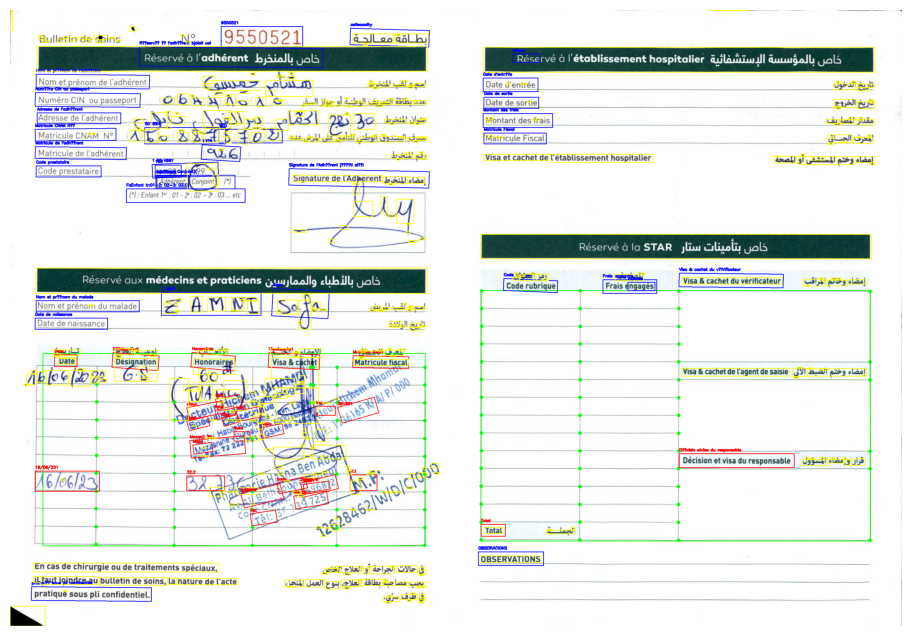

[INFO] Données combinées sauvegardées dans combined_layout.json


In [12]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import re
from paddleocr import PaddleOCR
import json

# Configuration OCR
OCR_ENGINE = PaddleOCR(
    use_angle_cls=True,
    lang="fr",
    use_gpu=False,
    det_db_thresh=0.4,
    det_db_box_thresh=0.5,
    det_db_unclip_ratio=2.0,
    rec_algorithm="SVTR_LCNet",
    max_text_length=100,
)

# -------- FONCTIONS DE DÉTECTION DE TABLEAUX --------
def adaptive_threshold(imagename, process_background=False, blocksize=15, c=-2):
    img = cv2.imread(imagename)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if process_background:
        threshold = cv2.adaptiveThreshold(
            gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, blocksize, c
        )
    else:
        threshold = cv2.adaptiveThreshold(
            np.invert(gray),
            255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY,
            blocksize,
            c,
        )
    return img, threshold

def find_lines(threshold, regions=None, direction="horizontal", line_scale=15, iterations=0):
    lines = []
    if direction == "vertical":
        size = threshold.shape[0] // line_scale
        el = cv2.getStructuringElement(cv2.MORPH_RECT, (1, size))
    elif direction == "horizontal":
        size = threshold.shape[1] // line_scale
        el = cv2.getStructuringElement(cv2.MORPH_RECT, (size, 1))
    else:
        raise ValueError("Direction doit être 'vertical' ou 'horizontal'")

    if regions is not None:
        region_mask = np.zeros(threshold.shape)
        for region in regions:
            x, y, w, h = region
            region_mask[y:y + h, x:x + w] = 1
        threshold = np.multiply(threshold, region_mask)

    threshold = cv2.erode(threshold, el)
    threshold = cv2.dilate(threshold, el)
    dmask = cv2.dilate(threshold, el, iterations=iterations)

    try:
        _, contours, _ = cv2.findContours(
            threshold.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )
    except ValueError:
        contours, _ = cv2.findContours(
            threshold.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )

    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        x1, x2 = x, x + w
        y1, y2 = y, y + h
        if direction == "vertical":
            lines.append(((x1 + x2) // 2, y2, (x1 + x2) // 2, y1))
        elif direction == "horizontal":
            lines.append((x1, (y1 + y2) // 2, x2, (y1 + y2) // 2))
    return dmask, lines

def find_contours(vertical, horizontal):
    mask = vertical + horizontal
    try:
        _, contours, _ = cv2.findContours(
            mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )
    except ValueError:
        contours, _ = cv2.findContours(
            mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]
    cont = []
    for c in contours:
        c_poly = cv2.approxPolyDP(c, 3, True)
        x, y, w, h = cv2.boundingRect(c_poly)
        cont.append((x, y, w, h))
    return cont, mask

def find_joints(contours, vertical, horizontal):
    joints = np.multiply(vertical, horizontal)
    tables = {}
    for c in contours:
        x, y, w, h = c
        roi = joints[y:y + h, x:x + w]
        try:
            _, jc, _ = cv2.findContours(
                roi.astype(np.uint8), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE
            )
        except ValueError:
            jc, _ = cv2.findContours(
                roi.astype(np.uint8), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE
            )
        if len(jc) <= 4:
            continue
        joint_coords = []
        for j in jc:
            jx, jy, jw, jh = cv2.boundingRect(j)
            c1, c2 = x + (2 * jx + jw) // 2, y + (2 * jy + jh) // 2
            joint_coords.append((c1, c2))
        tables[(x, y + h, x + w, y)] = joint_coords
    return tables

# -------- FONCTIONS D'EXTRACTION DES CHAMPS --------
def contains_arabic(text):
    return bool(re.search("[\u0600-\u06FF]", text))

def is_likely_handwritten(text, box, image):
    width = box[2][0] - box[0][0]
    height = box[2][1] - box[0][1]
    aspect_ratio = width / height if height > 0 else 0
    if aspect_ratio < 0.5 or aspect_ratio > 10 or len(text) < 3:
        return True
    return False

def is_likely_field_name(text):
    text = text.strip().upper()
    word_count = len(text.split())
    if word_count > 6:
        return False

    field_keywords = [
        "NOM", "PRENOM", "ADRESSE", "MATRICULE", "DATE", "MONTANT", "CODE",
        "VISA", "HONORAIRES", "DESIGNATION", "TOTAL", "OBSERVATIONS", "FRAIS",
        "NUMERO", "SIGNATURE", "RESERVE", "SORTIE", "ENTREE", "MATRICULE FISCAL"
    ]
    if any(keyword in text for keyword in field_keywords):
        return True

    non_field_patterns = [
        r"BULLETIN DE SOINS",
        r"RESERVE A L'ETABLISSEMENT HOSPITALIER",
        r"RESERVE A STAR",
        r"RESERVE AUX MEDECINS ET PRATICIENS",
        r"POUR LES CHIRURGIES OU DE TRAITEMENTS SPECIAUX",
        r"IL FAUT JOINDRE AU BULLETIN DE SOINS"
    ]
    if any(re.search(pattern, text, re.IGNORECASE) for pattern in non_field_patterns):
        return False

    if len(text) > 50:
        return False

    return True

def preprocess_image(image, mode):
    image_np = np.array(image)
    if mode == "grayscale":
        return cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
    elif mode == "rgb":
        return image_np
    elif mode == "binary":
        gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
        return cv2.adaptiveThreshold(
            gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, -2
        )
    elif mode == "contrast":
        img_lab = cv2.cvtColor(image_np, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(img_lab)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
        l = clahe.apply(l)
        img_lab = cv2.merge((l, a, b))
        return cv2.cvtColor(img_lab, cv2.COLOR_LAB2RGB)
    else:
        raise ValueError(f"Mode {mode} non supporté.")

def boxes_overlap(box1, box2, threshold=0.5):
    """Vérifie si deux boîtes se chevauchent (IoU).
    - box1: Liste de 4 points [[x1, y1], [x2, y1], [x2, y2], [x1, y2]] (texte tapé).
    - box2: Peut être soit [[x1, y1], [x2, y1], [x2, y2], [x1, y2]] (OCR), soit [x1, y1, x2, y2] (manuscrit).
    """
    # Normaliser box1 (toujours au format OCR)
    x1 = min(point[0] for point in box1)
    y1 = min(point[1] for point in box1)
    x2 = max(point[0] for point in box1)
    y2 = max(point[1] for point in box1)

    # Normaliser box2 (gérer les deux formats possibles)
    if len(box2) == 4 and isinstance(box2[0], list):  # Format OCR
        x1_p = min(point[0] for point in box2)
        y1_p = min(point[1] for point in box2)
        x2_p = max(point[0] for point in box2)
        y2_p = max(point[1] for point in box2)
    else:  # Format manuscrit [x1, y1, x2, y2]
        x1_p, y1_p, x2_p, y2_p = box2

    # Calcul de l'intersection
    xi1 = max(x1, x1_p)
    yi1 = max(y1, y1_p)
    xi2 = min(x2, x2_p)
    yi2 = min(y2, y2_p)

    inter_width = max(0, xi2 - xi1)
    inter_height = max(0, yi2 - yi1)
    inter_area = inter_width * inter_height

    # Calcul des aires
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2_p - x1_p) * (y2_p - y1_p)
    union_area = box1_area + box2_area - inter_area

    iou = inter_area / union_area if union_area > 0 else 0
    return iou > threshold

def extract_text_and_layout(image):
    modes = ["grayscale", "rgb", "binary", "contrast"]
    extracted_data = []

    for mode in modes:
        print(f"[INFO] Application de l'OCR avec le mode {mode}")
        preprocessed_img = preprocess_image(image, mode)
        results = OCR_ENGINE.ocr(preprocessed_img, cls=True)

        if results is None:
            continue
        for line in results:
            if line is None:
                continue
            for word_info in line:
                if word_info is None:
                    continue
                text = word_info[1][0]
                confidence = word_info[1][1]
                box = word_info[0]

                text = text.replace("??", "é").replace("??", "à").strip()

                if confidence < 0.7:
                    continue
                if contains_arabic(text):
                    continue
                if is_likely_handwritten(text, box, preprocessed_img):
                    continue
                if len(text) < 2:
                    continue

                overlaps = False
                for existing in extracted_data:
                    if boxes_overlap(existing["box"], box):
                        overlaps = True
                        break

                if not overlaps:
                    extracted_data.append({"text": text, "box": box})

    print(f"[INFO] Nombre total de boîtes détectées : {len(extracted_data)}")
    return extracted_data

def filter_field_names(extracted_data):
    filtered_data = []
    for item in extracted_data:
        text = item["text"]
        if is_likely_field_name(text):
            filtered_data.append(item)
    return filtered_data

# -------- FONCTIONS POUR TEXTE MANUSCRIT --------
def thresholding(image):
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(img_gray, 80, 255, cv2.THRESH_BINARY_INV)
    return thresh

def detect_handwritten_text(image, thresh_img):
    kernel = np.ones((3, 85), np.uint8)  # Pour lignes
    dilated = cv2.dilate(thresh_img, kernel, iterations=1)
    (contours, _) = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    sorted_contours_lines = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[1])

    kernel2 = np.ones((3, 15), np.uint8)  # Pour mots
    dilated2 = cv2.dilate(thresh_img, kernel2, iterations=1)
    words_list = []

    for line in sorted_contours_lines:
        x, y, w, h = cv2.boundingRect(line)
        roi_line = dilated2[y:y+h, x:x+w]
        (cnt, _) = cv2.findContours(roi_line.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        sorted_contour_words = sorted(cnt, key=lambda cntr: cv2.boundingRect(cntr)[0])

        for word in sorted_contour_words:
            if cv2.contourArea(word) < 50:  # Filtrer petits contours
                continue
            x2, y2, w2, h2 = cv2.boundingRect(word)
            words_list.append([x+x2, y+y2, x+x2+w2, y+y2+h2])
    return words_list

# -------- FONCTIONS D'ANNOTATION ET SAUVEGARDE --------
def is_inside_table(box, table_bbox):
    box_center_x = (box[0][0] + box[2][0]) / 2
    box_center_y = (box[0][1] + box[2][1]) / 2
    for key in table_bbox.keys():
        x1, y2, x2, y1 = key
        if x1 <= box_center_x <= x2 and y1 <= box_center_y <= y2:
            return True
    return False

def annotate_combined_image(image_path, table_bbox, typed_text_data, handwritten_boxes, output_path="combined_result.jpg"):
    image = cv2.imread(image_path)
    if image is None:
        print("[ERROR] Impossible de charger l'image pour l'annotation.")
        return
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Tableaux (vert)
    for tab in table_bbox.keys():
        x1, y2, x2, y1 = tab
        cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        for cord in table_bbox[tab]:
            image = cv2.circle(image, (cord[0], cord[1]), radius=7, color=(0, 255, 0), thickness=-1)

    # Texte tapé (bleu hors tableaux, rouge dans tableaux)
    for item in typed_text_data:
        box = np.array(item["box"], np.int32).reshape((-1, 1, 2))
        color = (255, 0, 0) if is_inside_table(item["box"], table_bbox) else (0, 0, 255)
        cv2.polylines(image, [box], isClosed=True, color=color, thickness=2)
        text_x, text_y = box[0][0][0], box[0][0][1] - 10
        cv2.putText(image, item["text"], (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2, cv2.LINE_AA)

    # Texte manuscrit (jaune)
    for box in handwritten_boxes:
        x1, y1, x2, y2 = box
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 255, 0), 2)

    cv2.imwrite(output_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

def save_combined_data(table_bbox, typed_text_data, handwritten_boxes, filename="combined_layout.json"):
    """Sauvegarde les données combinées dans un fichier JSON."""
    # Convertir les clés de table_bbox (tuples) en chaînes
    serializable_table_bbox = {str(key): value for key, value in table_bbox.items()}
    
    combined_data = {
        "tables": serializable_table_bbox,
        "typed_text": typed_text_data,
        "handwritten_text": handwritten_boxes
    }
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(combined_data, f, ensure_ascii=False, indent=4)
    print(f"[INFO] Données combinées sauvegardées dans {filename}")

# -------- FONCTION PRINCIPALE --------
def main(doc_path):
    # Étape 1 : Préparation de l'image et détection des tableaux
    img, threshold = adaptive_threshold(doc_path, process_background=False, blocksize=15, c=-2)
    vertical_mask, vertical_segments = find_lines(threshold, direction="vertical", line_scale=15, iterations=0)
    horizontal_mask, horizontal_segments = find_lines(threshold, direction="horizontal", line_scale=15, iterations=0)
    contours, mask = find_contours(vertical_mask, horizontal_mask)
    table_bbox = find_joints(contours, vertical_mask, horizontal_mask)

    # Filtrer les tableaux trop grands
    image_height, image_width = img.shape[:2]
    image_area = image_height * image_width
    threshold_area_ratio = 0.9
    filtered_table_bbox = {}
    for tab, joints in table_bbox.items():
        x1, y2, x2, y1 = tab
        table_area = (x2 - x1) * (y2 - y1)
        if table_area / image_area < threshold_area_ratio:
            filtered_table_bbox[tab] = joints
    table_bbox = filtered_table_bbox

    # Étape 2 : Extraction du texte tapé avec OCR
    image_pil = Image.open(doc_path).convert("RGB")
    extracted_data = extract_text_and_layout(image_pil)
    typed_text_data = filter_field_names(extracted_data)

    # Étape 3 : Détection du texte manuscrit
    thresh_img = thresholding(img)
    handwritten_boxes = detect_handwritten_text(img, thresh_img)

    # Étape 4 : Filtrer les chevauchements entre texte tapé et manuscrit
    final_handwritten_boxes = []
    for h_box in handwritten_boxes:
        overlap = False
        for t_item in typed_text_data:
            t_box = t_item["box"]
            if boxes_overlap(t_box, h_box):
                overlap = True
                break
        if not overlap:
            final_handwritten_boxes.append(h_box)

    # Étape 5 : Annoter l'image combinée
    annotate_combined_image(doc_path, table_bbox, typed_text_data, final_handwritten_boxes)

    # Étape 6 : Sauvegarder les données combinées
    save_combined_data(table_bbox, typed_text_data, final_handwritten_boxes)

if __name__ == "__main__":
    document_path = r"C:\Users\jlassi\Desktop\testYolo\notebooks\0753--9550521--20230705_page_0.jpg"
    main(document_path)